Miniset and Validation Data set

## Reference
1. https://www.kaggle.com/code/neslihanozeryildiz/creating-mini-data-sets-and-validation-data-set#Examining-Original-Data-Set

## Config and Import

In [1]:
from pathlib import Path
import os

import json
import itertools
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import warnings

In [2]:
DATA_PATH = '../input/pii-detection-removal-from-educational-data'
OUTPUT_DIR = '/kaggle/working/'

#print files with pathname
for dirname, _, filenames in os.walk(DATA_PATH):
    for filename in filenames:
        print(os.path.join(dirname, filename))

../input/pii-detection-removal-from-educational-data/sample_submission.csv
../input/pii-detection-removal-from-educational-data/train.json
../input/pii-detection-removal-from-educational-data/test.json


## helper functions


In [3]:
#split data into training and validation set
def PIId2_split_by_sampling(df, test_ratio):
    """Split PII data into training and test set. 

    Args:
        df (pd.DataFrame): The input DataFrame.
        test_ratio (float, default=0.2): 
            The proportion of the dataset to include in the test split.

    Returns:
        train_df, test_df: Training and test splits of the input DataFrame.
    """
    # Get the number of rows in the DataFrame
    num_rows = len(df)
    
    # Get the split index
    split_idx = int(num_rows * test_ratio)
    
    # Shuffle the DataFrame rows
    df_shuffled = df.sample(frac=1, random_state=42)
    
    # Split the DataFrame into train and test
    train_df = df_shuffled.iloc[split_idx:]
    test_df = df_shuffled.iloc[:split_idx]
    
    return train_df, test_df

In [4]:
def move_missing_labels(to_df, from_df):
    """
    Move documents containing missing labels from the extra DataFrame to the desired DataFrame.

    Parameters:
    - to_df (DataFrame): DataFrame where the documents should be moved to.
    - from_df (DataFrame): DataFrame where the documents should be moved from.

    Returns:
    - desired_df, extra_df: Updated DataFrames.
    """
    # Find the labels that are missing from the to_df DataFrame
    missing_labels = set(from_df['provided_labels'].explode().unique()) - set(to_df['provided_labels'].explode().unique())

    # For each missing label, move a document from the extra DataFrame to the desired DataFrame
    for label in missing_labels:
        if label in from_df['provided_labels'].explode().unique():
            document = from_df[from_df['provided_labels'].apply(lambda x: label in x)].sample(n=1)
            to_df = pd.concat([to_df, document])
            from_df = from_df.drop(document.index)

    return to_df, from_df

In [5]:
import matplotlib.pyplot as plt

def graph_label_compare(left_df, right_df, left_title, right_title):
    """
    Compare the label distributions of two DataFrames.

    Parameters:
    - left_df (DataFrame): First DataFrame to compare.
    - right_df (DataFrame): Second DataFrame to compare.
    - left_title (str): Title for the first DataFrame's plot.
    - right_title (str): Title for the second DataFrame's plot.
    """
    # Calculate the distribution of labels in the left DataFrame
    left_labels = left_df['provided_labels'].explode()
    left_labels = left_labels[left_labels != 'O']  # Exclude 'O' labels
    left_label_distribution = left_labels.value_counts(normalize=True) * 100

    # Calculate the distribution of labels in the right DataFrame
    right_labels = right_df['provided_labels'].explode()
    right_labels = right_labels[right_labels != 'O']  # Exclude 'O' labels
    right_label_distribution = right_labels.value_counts(normalize=True) * 100

    # Create the figure for the plots
    plt.figure(figsize=(10, 4))

    # Create a bar plot for the left DataFrame label distribution
    plt.subplot(1, 2, 1)
    left_label_distribution.plot(kind='bar', color='blue', alpha=0.5, label=left_title)
    for i in range(len(left_label_distribution)):
        plt.text(i, left_label_distribution.iloc[i] + 0.5, f"{left_label_distribution.iloc[i]:.2f}%", ha='center', va='bottom')
    plt.title(f'{left_title} Label Distribution')
    plt.xlabel('Labels')
    plt.ylabel('%')
    plt.legend()

    # Create a bar plot for the right DataFrame label distribution
    plt.subplot(1, 2, 2)
    right_label_distribution.plot(kind='bar', color='pink', alpha=0.5, label=right_title)
    for i in range(len(right_label_distribution)):
        plt.text(i, right_label_distribution.iloc[i] + 0.5, f"{right_label_distribution.iloc[i]:.2f}%", ha='center', va='bottom')
    plt.title(f'{right_title} Label Distribution')
    plt.xlabel('Labels')
    plt.ylabel('%')
    plt.legend()

    # Display the plots
    plt.tight_layout()
    plt.show()

## Load Data

In [6]:
comp_train= json.load(open(DATA_PATH +'/train.json'))

#Convert to df for EDA
base_df= pd.DataFrame(comp_train)

#change base_df column labels to 'provided labels'
base_df = base_df.rename(columns={'labels': 'provided_labels'})

## Train and Validation split

## Validation set

In [7]:
train_df, val_df = PIId2_split_by_sampling(base_df, .1)
train_df_overlap = train_df

val_df, train_df = move_missing_labels(val_df, train_df)

size of base:  6807
size of val_df:  688


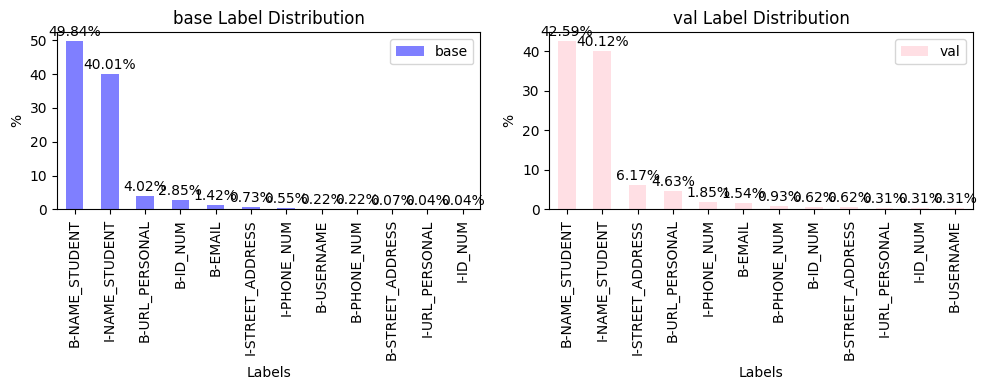

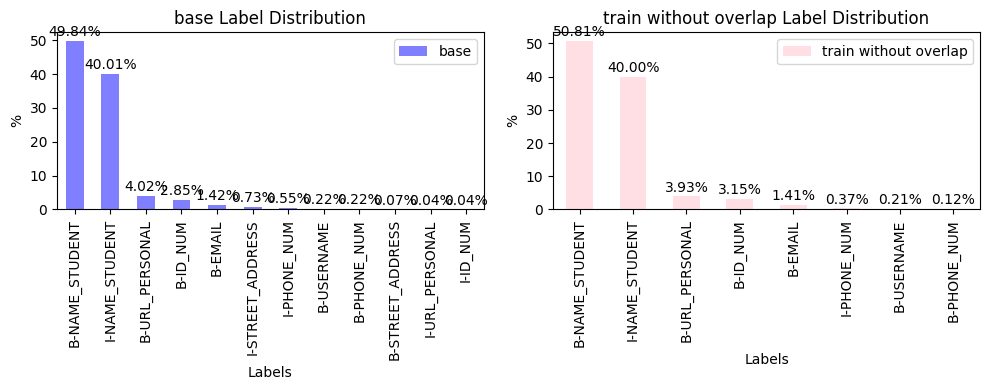

In [8]:
# Save the DataFrame to a JSON file 
val_df.to_json(OUTPUT_DIR + "/val.json", orient="records")
train_df.to_json(OUTPUT_DIR + "/train_df_fromval.json", orient="records")
train_df_overlap.to_json(OUTPUT_DIR + "/train_df_overlap_fromval.json", orient="records")

print("size of base: ", len(base_df))
print("size of val_df: ", len(val_df))

graph_label_compare(base_df, val_df, "base", "val")
graph_label_compare(base_df, train_df, "base", "train without overlap")

## Minisets
- mini no overlap ~25%
- mini overlap ~25%


In [9]:

mini_overlap, overlap_extra = PIId2_split_by_sampling(train_df_overlap, .7)
mini_no_overlap, no_overlap_extra= PIId2_split_by_sampling(train_df, .7)


mini_overlap, overlap_extra = move_missing_labels(mini_overlap, overlap_extra)
mini_no_overlap, no_overlap_extra= move_missing_labels(mini_no_overlap, no_overlap_extra)

size of base:  6807
size of mini_overlap:  1843
size of mini_no_overlap:  1838


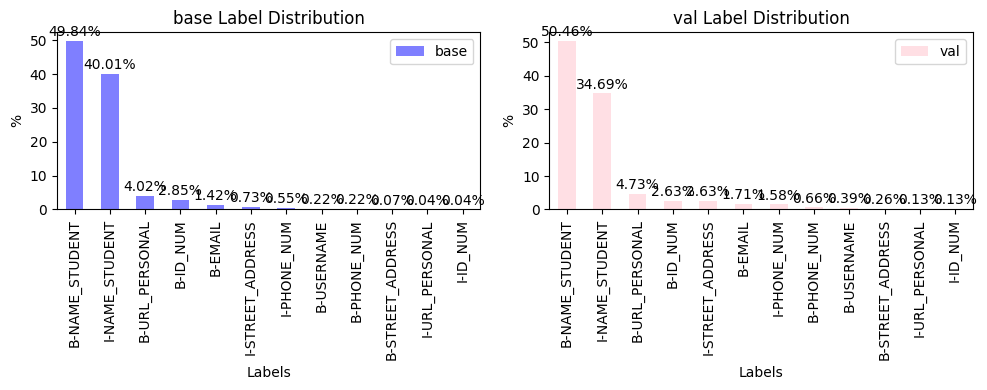

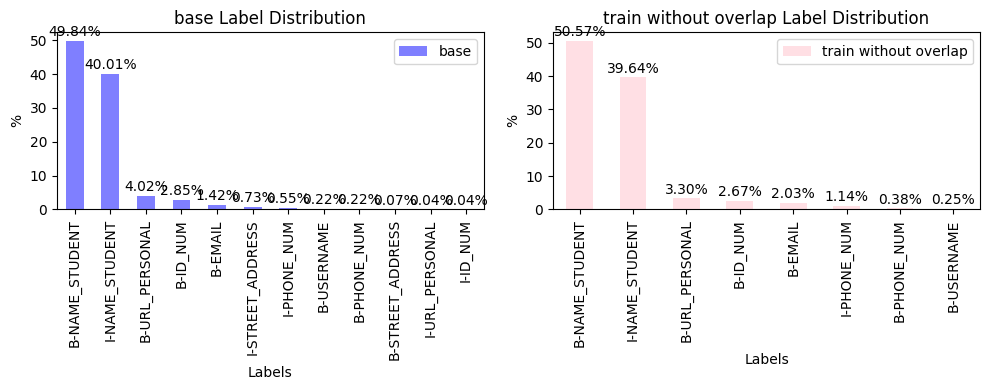

In [10]:
# Save the DataFrame to a JSON file 
mini_overlap.to_json(OUTPUT_DIR + "/mini_overlap.json", orient="records")
mini_no_overlap.to_json(OUTPUT_DIR + "/mini_no_overlap.json", orient="records")

print("size of base: ", len(base_df))
print("size of mini_overlap: ", len(mini_overlap))
print("size of mini_no_overlap: ", len(mini_no_overlap))
graph_label_compare(base_df, mini_overlap, "base", "val")
graph_label_compare(base_df, mini_no_overlap, "base", "train without overlap")